In [ ]:
import os

os.environ['TF_AUTOTUNE_THRESHOLD'] = '0'

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, BatchNormalization, AveragePooling2D, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal
import torch.optim as optim
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
# Print CUDA version
print("CUDA version:", tf.sysconfig.get_build_info()["cuda_version"])

# Print cuDNN version
print("cuDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])

CUDA version: 12.2
cuDNN version: 8


In [23]:
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


In [24]:
X = np.load("/kaggle/input/final-data/X.npy")
y = np.load("/kaggle/input/final-data/y.npy")

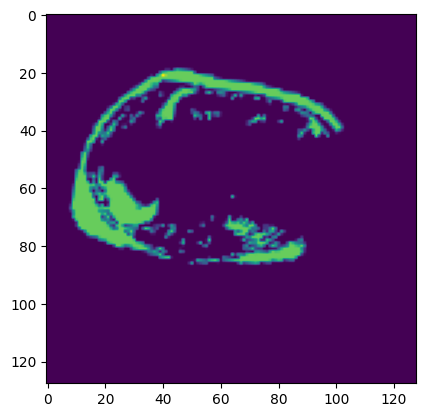

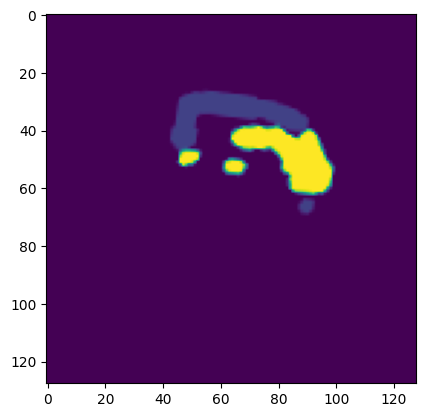

In [25]:
#print(x[0])

i = 3995

imgplot = plt.imshow(X[i])
plt.show()

imgplot = plt.imshow(y[i])
plt.show()

In [26]:
def conv_block(inputs, num_filters):
    out = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=HeNormal())(inputs)
    out = LeakyReLU(alpha=0.01)(out)
    
    out = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer=HeNormal())(out)
    out = LeakyReLU(alpha=0.01)(out)
    
    out = Dropout(0.3)(out)
    
    return out

In [27]:
def enc_block(inputs, num_filters):
    s = conv_block(inputs, num_filters)
    p = AveragePooling2D(pool_size=(2, 2))(s)
    
    return s, p
    

In [28]:
def dec_block(inputs, skip_feat, num_filters):
    out = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", kernel_initializer=HeNormal())(inputs)
    out = Concatenate()([out, skip_feat])
    out = conv_block(out, num_filters)
    
    return out 

In [29]:
def build_unet(input_shape):
    
    inputs = Input(shape=input_shape)
    
    #encoder
    s1, p1 = enc_block(inputs, 32)
    s2, p2 = enc_block(p1, 64)
    s3, p3 = enc_block(p2, 128)

    #bridge
    b = conv_block(p3, 256)

    #decoder
    d1 = dec_block(b, s3, 128)
    d2 = dec_block(d1, s2, 64)
    d3 = dec_block(d2, s1, 32)

    #output
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs, name="U-net")
    return model

In [30]:
input_shape = (128, 128, 1)

model = build_unet(input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [31]:
idx1 = int(0.75*len(X));
idx2 = int(0.9*len(X));

X_train = X[:idx1]
y_train = y[:idx1]
X_val = X[idx1:idx2]
y_val = y[idx1:idx2]
X_test = X[idx2:]
y_test = y[idx2:]

In [32]:
len(X_train)

3855

In [14]:
batch_size = 200

In [25]:
#from tensorflow.keras import mixed_precision

# Set the mixed precision policy to 'mixed_float16'
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

#tf.keras.mixed_precision.set_global_policy('float32')

In [33]:
from tensorflow.keras.metrics import BinaryIoU, Precision, Recall, BinaryAccuracy

# Compile the model
optim = Adam(clipnorm=1.0)
model.compile(optimizer=optim, loss='binary_crossentropy', metrics = [
    
    BinaryIoU(threshold=0.5, target_class_ids=[1], name='iou'), 
    Precision(name='precision'),
    Recall(name='recall'),
    BinaryAccuracy(name='accuracy')
    
])

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
tf.keras.backend.clear_session()

In [19]:
tf.random.set_seed(1)

In [17]:
X_train = np.array(X_train)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_val = np.array(y_val)

In [18]:
X_train = X_train.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)
y_train = X_train.reshape(-1, 128, 128, 1)
y_val = X_val.reshape(-1, 128, 128, 1)

In [34]:
with tf.device('/GPU:0'):
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping]#, tensorboard_callback]
    )

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9045 - iou: 0.0000e+00 - loss: 0.3204 - precision: 0.0406 - recall: 0.0586 - val_accuracy: 0.9605 - val_iou: 0.0000e+00 - val_loss: 0.1632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 387ms/step - accuracy: 0.9599 - iou: 0.0000e+00 - loss: 0.1683 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9605 - val_iou: 0.0000e+00 - val_loss: 0.1632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 388ms/step - accuracy: 0.9597 - iou: 0.0000e+00 - loss: 0.1703 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9605 - val_iou: 0.0000e+00 - val_loss: 0.1632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 387ms/step - accuracy: 0.9598 - iou: 0.0000e+00 - loss: 0.1712 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9605 - val_iou: 0.0000e+00 - val_loss: 0.1632 - v